# CNN Model for MNIST Detection

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [3]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [4]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
sanity_images = test_images[:10]
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
sanity_labels = test_labels[:10]

In [5]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

sess = tf.Session()
keras.backend.set_session(sess)

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])


W0604 17:18:06.070565 4467701184 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 16s 261us/sample - loss: 1.0120 - categorical_accuracy: 0.6693 - val_loss: 0.3164 - val_categorical_accuracy: 0.9122
Epoch 2/12
60000/60000 [==============================] - 15s 256us/sample - loss: 0.4612 - categorical_accuracy: 0.8579 - val_loss: 0.2340 - val_categorical_accuracy: 0.9330
Epoch 3/12
60000/60000 [==============================] - 15s 252us/sample - loss: 0.3723 - categorical_accuracy: 0.8863 - val_loss: 0.1943 - val_categorical_accuracy: 0.9419
Epoch 4/12
60000/60000 [==============================] - 15s 249us/sample - loss: 0.3231 - categorical_accuracy: 0.9015 - val_loss: 0.1652 - val_categorical_accuracy: 0.9499
Epoch 5/12
60000/60000 [==============================] - 17s 285us/sample - loss: 0.2815 - categorical_accuracy: 0.9150 - val_loss: 0.1449 - val_categorical_accuracy: 0.9560
Epoch 6/12
60000/60000 [==============================] - 17s 286us/sample 

# Attack Utilities

In [13]:
timages = tf.constant(test_images)
tlabels = tf.constant(test_labels)

In [6]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target_labels, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 3
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    ret_score = score[1] if targeted else 1 - score[1]
    return ret_score, dist

# Part I - TF Implementation for PGD Attack

## 1. FGSM and TGSM implementations against the MNIST testing set

In [16]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FGSM(model, images, labels, epsilon=0.3):  
    adv_loss = keras.losses.categorical_crossentropy(labels, model(images))
    grads_wrt_input, = keras.backend.gradients(adv_loss, images)
    sign_grads = keras.backend.sign(grads_wrt_input)
    
    delta = epsilon * sign_grads
    images_adv  = images + delta
    
    return images_adv

Test loss: 6.18
Successfully moved out of source class: 0.98
Mean perturbation distance: 0.29


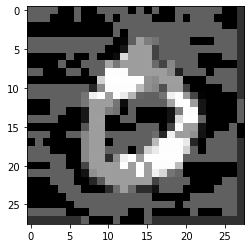

(0.9790000002831221, 0.29120785)

In [17]:
# run session
sess = keras.backend.get_session()
images_adv = FGSM(model, timages, tlabels)
adv_out = sess.run(images_adv)

# test results
TestAttack(model, adv_out, test_images, test_labels, targeted=False)

In [19]:
''' Targeted Gradient Sign Method implementation - A targeted variant of the FGSM attack
    here we minimize the loss with respect to the target class, as opposed to maximizing the loss with respect
    to the source class
'''
def TGSM(model, images, target, epsilon=0.3):
    adv_loss = keras.losses.categorical_crossentropy(target, model(images))
    grads_wrt_input, = keras.backend.gradients(adv_loss, images)
    sign_grads = keras.backend.sign(grads_wrt_input)
    
    delta = epsilon * sign_grads
    images_adv  = images - delta    
    
    return images_adv

Test loss: 5.03
Successfully moved out of source class: 0.95
Test loss: 1.45
Successfully perturbed to target class: 0.53
Mean perturbation distance: 0.29


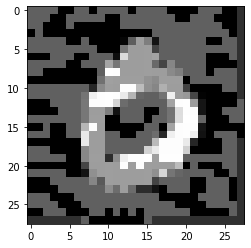

(0.5345, 0.29120785)

In [21]:
# Choose random target classes per each instance in the test set
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
ttarget = tf.constant(target)

# run session
sess = keras.backend.get_session()
images_adv = TGSM(model, timages, ttarget)
adv_out = sess.run(images_adv)

# test results
TestAttack(model, adv_out, test_images, test_labels, target, targeted=True)

## 2. PGD Implementation


*   Perform projection step only when exceeding allowed radius
*   Different constants for overall perturbation distance and iteration step size
*   Support for targeted and untargerted
*   Clipping to allowed values (0,1)
*   Numerical stability (no zero division)
*   Batch attacks in a single call



In [41]:
def PGD(model, images, labels, epsilon=0.1, iter_eps=0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False):
    # support batch  pertrubation
    adv_out = images
    
    # loop stop condition
    cond = lambda i, _: tf.less(i, iterations)
    
    # loop body
    def body(i, adv_out):
        # support targeted and untargeted
        if targeted:
            adv_out = TGSM(model, adv_out, labels, epsilon=iter_eps)  # different eps constants
        else:
            adv_out = FGSM(model, adv_out, labels, epsilon=iter_eps)  # different eps constants

        perturbation = adv_out - images
        # clip to allowed epsilon radius
        norm = tf.reduce_sum(tf.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = tf.sqrt(tf.maximum(1e-11, norm))  # assure numerical stability
        factor = tf.minimum(1., tf.math.divide(epsilon, norm))  # perform projection when exceeding radius
        adv_out = images + perturbation * factor
        adv_out = tf.clip_by_value(adv_out, min_x, max_x)  # clip outputs to allowed values
        
        return i+1, adv_out
    
    _, adv_out = tf.while_loop(cond, body, (tf.zeros([]), adv_out), back_prop=True,
                             maximum_iterations=iterations)
    
    return adv_out

Test loss: 6.02
Successfully moved out of source class: 0.97
Mean perturbation distance: 0.14


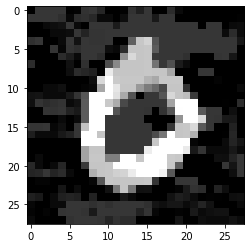

(0.9662999995052814, 0.14078593)

In [44]:
# run session
sess = keras.backend.get_session()
adv_images = PGD(model, test_images, tlabels, iterations=30, epsilon=4.0, iter_eps=0.05, targeted=False)
adv_out = sess.run(adv_images)

# test results
TestAttack(model, adv_out, test_images, test_labels, target, targeted=False)

## 3. Test PGD implementation over MNIST

In [46]:
experiments = [
  {
    'labels': tlabels, 
    'iterations': 30, 
    'epsilon': 4.0, 
    'iter_eps': 0.05, 
    'targeted': False
  },
  {
    'labels': tlabels, 
    'iterations': 30, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': False
  },
  {
    'labels': tlabels,
    'iterations': 60, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': False
  },
  {
    'labels': ttarget, 
    'iterations': 30, 
    'epsilon': 4.0, 
    'iter_eps': 0.05, 
    'targeted': True
  },
  {
    'labels': ttarget, 
    'iterations': 30, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': True
  },
  {
    'labels': ttarget, 
    'iterations': 60, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': True
  }
]

Experiment #1
Test loss: 6.02
Successfully moved out of source class: 0.97
Mean perturbation distance: 0.14


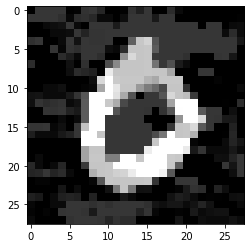

Experiment #2
Test loss: 3.20
Successfully moved out of source class: 0.80
Mean perturbation distance: 0.11


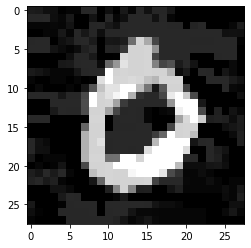

Experiment #3
Test loss: 3.20
Successfully moved out of source class: 0.80
Mean perturbation distance: 0.11


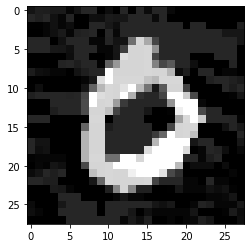

Experiment #4
Test loss: 3.29
Successfully moved out of source class: 0.82
Test loss: 0.67
Successfully perturbed to target class: 0.80
Mean perturbation distance: 0.14


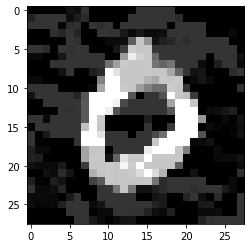

Experiment #5
Test loss: 1.39
Successfully moved out of source class: 0.46
Test loss: 2.13
Successfully perturbed to target class: 0.42
Mean perturbation distance: 0.11


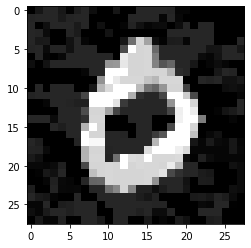

Experiment #6
Test loss: 1.38
Successfully moved out of source class: 0.45
Test loss: 2.13
Successfully perturbed to target class: 0.42
Mean perturbation distance: 0.11


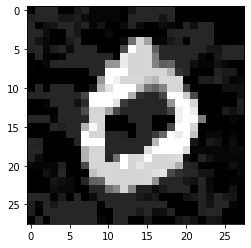

In [47]:
scores = []
for i, experiment in enumerate(experiments):
    print(f"Experiment #{i+1}")
    
    # run session
    sess = keras.backend.get_session()
    adv_images = PGD(model, test_images, **experiment)
    adv_out = sess.run(adv_images)

    # test results
    ex_score = TestAttack(model, adv_out, test_images, test_labels, target, targeted=experiment['targeted'])
    scores.append(ex_score)

In [48]:
scores

[(0.9662999995052814, 0.14078593),
 (0.7990999966859818, 0.10607572),
 (0.8021000027656555, 0.10607013),
 (0.7969, 0.14094576),
 (0.4214, 0.1061428),
 (0.4204, 0.10613752)]

# Part II - Beyond GPD

In [49]:
def get_frame_mask(tensor):
    """
    A utility function that returns a frame numpy array
    given two dimensions, where the frame pixels are of value 0
    and non-frame pixels are of value 1
    """
    shape = tensor.shape
    frame = np.ones((shape[1], shape[2]), dtype=tensor.dtype)
    frame[0, :] = 0
    frame[shape[1] - 1, :] = 0
    frame[:, 0] = 0
    frame[:, shape[2] - 1] = 0
    frame = np.tile(frame, (shape[0], 1, 1))
    frame = np.expand_dims(frame, axis=-1)  # return to original shape
    return frame

In [50]:
def get_black_mask(tensor):
    """
    A utility function that returns a mask numpy array
    given a tensor, where the black pixels are of value 0
    and non-black pixels are of value 1
    """
    return (tensor != 0).astype(tensor.dtype)

In [51]:
def PGD2(model, images, labels, epsilon=0.1, iter_eps=0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False,
         restrict_frame=False, restrict_black=False):
    
    # support batch  pertrubation
    adv_out = images
    
    if restrict_frame:
        frame_mask = tf.constant(get_frame_mask(images))
        
    if restrict_black:
        black_mask = tf.constant(get_black_mask(images))
    
    # loop stop condition
    cond = lambda i, _: tf.less(i, iterations)
    
    # loop body
    def body(i, adv_out):
        # support targeted and untargeted
        if targeted:
            adv_out = TGSM(model, adv_out, labels, epsilon=iter_eps)  # different eps constants
        else:
            adv_out = FGSM(model, adv_out, labels, epsilon=iter_eps)  # different eps constants

        perturbation = adv_out - images
        # clip to allowed epsilon radius
        norm = tf.reduce_sum(tf.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = tf.sqrt(tf.maximum(1e-11, norm))  # assure numerical stability
        factor = tf.minimum(1., tf.math.divide(epsilon, norm))  # perform projection when exceeding radius
        
        # restrict certain parts of the image
        if restrict_frame:
            perturbation = perturbation * frame_mask
        if restrict_black:
            perturbation = perturbation * black_mask
        
        adv_out = images + perturbation * factor
        adv_out = tf.clip_by_value(adv_out, min_x, max_x)  # clip outputs to allowed values
        
        return i+1, adv_out
    
    _, adv_out = tf.while_loop(cond, body, (tf.zeros([]), adv_out), back_prop=True,
                             maximum_iterations=iterations)
    
    return adv_out

In [58]:
frame_experiments = [
  {
    'labels': tlabels, 
    'iterations': 30, 
    'epsilon': 4.0, 
    'iter_eps': 0.05, 
    'targeted': False,
    'restrict_frame': True,
    'restrict_black': False
  },
  {
    'labels': tlabels, 
    'iterations': 30, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': False,
    'restrict_frame': True,
    'restrict_black': False
  },
  {
    'labels': tlabels,
    'iterations': 60, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': False,
    'restrict_frame': True,
    'restrict_black': False
  },
  {
    'labels': ttarget, 
    'iterations': 30, 
    'epsilon': 4.0, 
    'iter_eps': 0.05, 
    'targeted': True,
    'restrict_frame': True,
    'restrict_black': False
  },
  {
    'labels': ttarget, 
    'iterations': 30, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': True,
    'restrict_frame': True,
    'restrict_black': False
  },
  {
    'labels': ttarget, 
    'iterations': 60, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': True,
    'restrict_frame': True,
    'restrict_black': False
  }
]

In [60]:
black_experiments = [
  {
    'labels': tlabels, 
    'iterations': 30, 
    'epsilon': 4.0, 
    'iter_eps': 0.05, 
    'targeted': False,
    'restrict_frame': False,
    'restrict_black': True
  },
  {
    'labels': tlabels, 
    'iterations': 30, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': False,
    'restrict_frame': False,
    'restrict_black': True
  },
  {
    'labels': tlabels,
    'iterations': 60, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': False,
    'restrict_frame': False,
    'restrict_black': True
  },
  {
    'labels': ttarget, 
    'iterations': 30, 
    'epsilon': 4.0, 
    'iter_eps': 0.05, 
    'targeted': True,
    'restrict_frame': False,
    'restrict_black': True
  },
  {
    'labels': ttarget, 
    'iterations': 30, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': True,
    'restrict_frame': False,
    'restrict_black': True
  },
  {
    'labels': ttarget, 
    'iterations': 60, 
    'epsilon': 3.0, 
    'iter_eps': 0.03, 
    'targeted': True,
    'restrict_frame': False,
    'restrict_black': True
  }
]

Experiment #1
Test loss: 6.50
Successfully moved out of source class: 0.97
Mean perturbation distance: 0.14


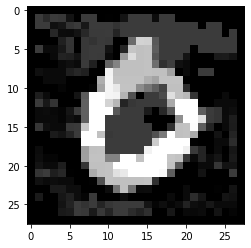

Experiment #2
Test loss: 3.51
Successfully moved out of source class: 0.83
Mean perturbation distance: 0.11


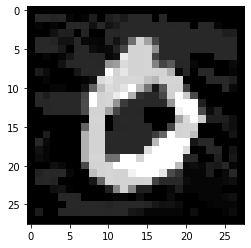

Experiment #3
Test loss: 3.52
Successfully moved out of source class: 0.83
Mean perturbation distance: 0.11


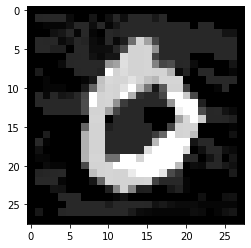

Experiment #4
Test loss: 3.68
Successfully moved out of source class: 0.85
Test loss: 0.55
Successfully perturbed to target class: 0.83
Mean perturbation distance: 0.14


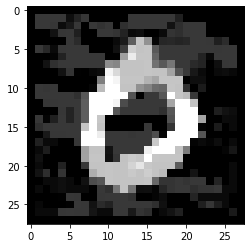

Experiment #5
Test loss: 1.58
Successfully moved out of source class: 0.51
Test loss: 1.90
Successfully perturbed to target class: 0.47
Mean perturbation distance: 0.11


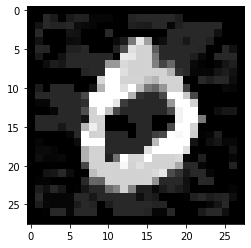

Experiment #6
Test loss: 1.57
Successfully moved out of source class: 0.50
Test loss: 1.90
Successfully perturbed to target class: 0.47
Mean perturbation distance: 0.11


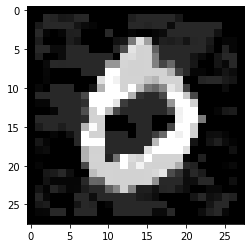

In [59]:
frame_scores = []
for i, frame_experiment in enumerate(frame_experiments):
    print(f"Experiment #{i+1}")
    
    # run session
    sess = keras.backend.get_session()
    adv_images = PGD2(model, test_images, **frame_experiment)
    adv_out = sess.run(adv_images)

    # test results
    ex_score = TestAttack(model, adv_out, test_images, test_labels, target, targeted=frame_experiment['targeted'])
    scores.append(ex_score)

Experiment #1
Test loss: 3.27
Successfully moved out of source class: 0.78
Mean perturbation distance: 0.14


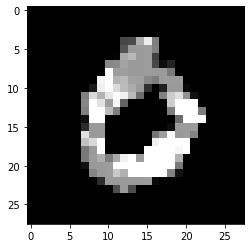

Experiment #2
Test loss: 1.69
Successfully moved out of source class: 0.51
Mean perturbation distance: 0.10


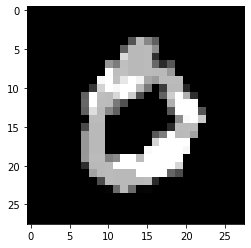

Experiment #3
Test loss: 1.68
Successfully moved out of source class: 0.50
Mean perturbation distance: 0.10


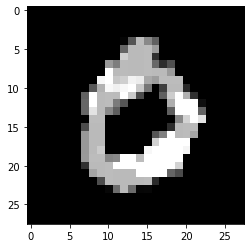

Experiment #4
Test loss: 1.40
Successfully moved out of source class: 0.44
Test loss: 2.31
Successfully perturbed to target class: 0.40
Mean perturbation distance: 0.14


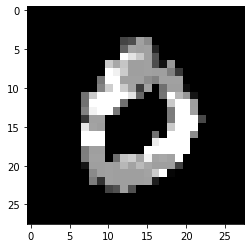

Experiment #5
Test loss: 0.63
Successfully moved out of source class: 0.20
Test loss: 4.14
Successfully perturbed to target class: 0.16
Mean perturbation distance: 0.10


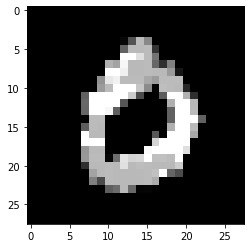

Experiment #6
Test loss: 0.62
Successfully moved out of source class: 0.19
Test loss: 4.16
Successfully perturbed to target class: 0.16
Mean perturbation distance: 0.10


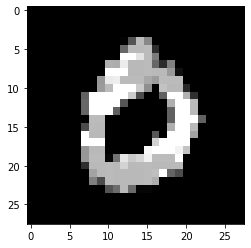

In [63]:
black_scores = []
for i, black_experiment in enumerate(black_experiments):
    print(f"Experiment #{i+1}")
    
    # run session
    sess = keras.backend.get_session()
    adv_images = PGD2(model, test_images, **black_experiment)
    adv_out = sess.run(adv_images)

    # test results
    ex_score = TestAttack(model, adv_out, test_images, test_labels, target, targeted=black_experiment['targeted'])
    scores.append(ex_score)